In [3]:
"""Librairies nécessaires"""

import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from tqdm import tqdm

In [4]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [6]:
"""Lecture du fichier des parcs"""
emplacement_parcs = '3.0) Enrichissement données/Données/Espaces_verts_parisiens.geojson'
df_espaces_verts_brut = gpd.read_file(emplacement_parcs, low_memory=False, index_col=0)

In [7]:
"""Les types d'espaces verts"""
df_espaces_verts_brut['categorie'].unique()
df_espaces_verts_brut['type_ev'].unique()

array(['Décorations sur la voie publique', 'Promenades ouvertes',
       'Jardinets décoratifs', 'Murs végétalisés', 'Jardins privatifs',
       'Ephémères, partagés, pédagogiques', 'Etablissements sportifs',
       'Périphérique', 'Cimetières', nan, 'Bois'], dtype=object)

In [8]:
"""Chargement des données administratives de Paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')

Text(0.5, 1.0, 'Carte des espaces verts retenus à Paris')

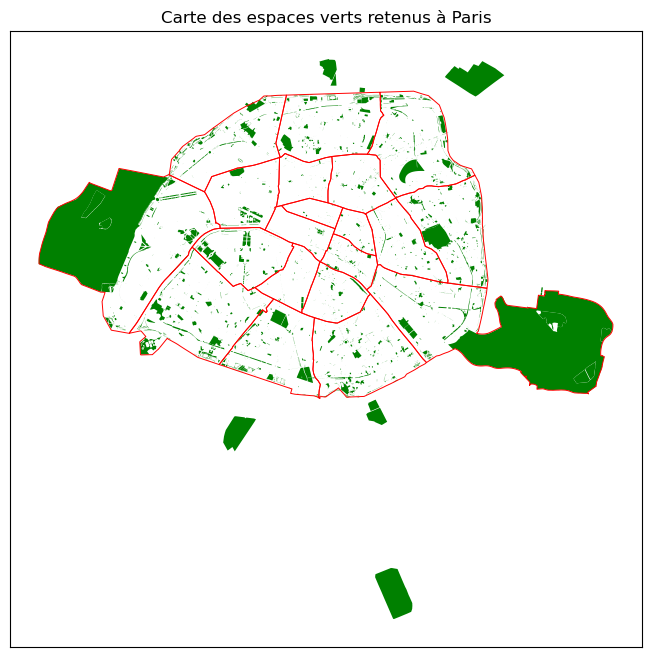

In [9]:
"""Visualisation des espaces verts sur une carte"""

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7)
df_espaces_verts_brut.plot(ax=ax, color='green')

plt.xticks([], [])
plt.yticks([], [])

plt.title('Carte des espaces verts retenus à Paris')

=============================================================

On voit qu'il manque le Jardin des plantes, des tuileries, et du Luxembourg (et ce, même dans le fichier de départ), car ils ne dépendent pas de la voirie de Paris, on va donc les rajouter manuellement.

Maintenant on cherche à calculer la distance minimale d'un appartement à un espace vert. Comme les espaces verts sont des polygones, on va, pour chaque appartement, trouver le projeté de ses coordonnées sur les polygones des espaces verts, puis sélectionner le projeté le plus proche. La procédure est détaillée en dessous.

=============================================================


In [10]:
"""On récupère manuellement les coordonnées des trois grands jardins qui manquent (car ils ne dépendent pas de la voierie de Paris)"""

coord_jardin_du_luxembourg = [
    [48.848583, 2.332634],
    [48.849056, 2.338542],
    [48.847234, 2.340275],
    [48.844127, 2.338816],
    [48.844720, 2.332550]
]

coord_jardin_des_plantes = [
    [48.846779, 2.360882],
    [48.843693, 2.364841],
    [48.841292, 2.356097],
    [48.843813, 2.355056]
]

coord_jardin_des_tuileries = [
    [48.866346, 2.323663],
    [48.863713, 2.331903],
    [48.861017, 2.329972],
    [48.863854, 2.321604]
]


In [11]:
"""Ajout des 3 parcs au fichier"""

# Convertir les coordonnées au format WGS 84
coord_jardin_des_plantes_wgs84 = [(lon, lat) for lat, lon in coord_jardin_des_plantes]
coord_jardin_des_tuileries_wgs84 = [(lon, lat) for lat, lon in coord_jardin_des_tuileries]
coord_jardin_du_luxembourg_wgs84 = [(lon, lat) for lat, lon in coord_jardin_du_luxembourg]

# Créer un GeoDataFrame avec le jardin des plantes
nouveau_jardin = gpd.GeoDataFrame({
    'nom_ev': ['JARDIN DES PLANTES'],
    'geometry': [Polygon(coord_jardin_des_plantes_wgs84)]
}, geometry='geometry')
nouveau_jardin.crs = "EPSG:4326"
nouveau_jardin['poly_area'] = nouveau_jardin['geometry'].to_crs(epsg=2154).area  # Conversion en mètres carrés
nouveau_jardin['adresse_codepostal'] = '75'
nouveau_jardin['categorie'] = 'Parc'
nouveau_jardin.crs = "EPSG:4326"

nouveau_jardin2 = gpd.GeoDataFrame({
    'nom_ev': ['JARDIN DES TUILERIES'],
    'geometry': [Polygon(coord_jardin_des_tuileries_wgs84)]
}, geometry='geometry')
nouveau_jardin2.crs = "EPSG:4326"
nouveau_jardin2['poly_area'] = nouveau_jardin2['geometry'].to_crs(epsg=2154).area
nouveau_jardin2['adresse_codepostal'] = '75'
nouveau_jardin2['categorie'] = 'Parc'
nouveau_jardin2.crs = "EPSG:4326"

nouveau_jardin3 = gpd.GeoDataFrame({
    'nom_ev': ['JARDIN DU LUXEMBOURG'],
    'geometry': [Polygon(coord_jardin_du_luxembourg_wgs84)]
}, geometry='geometry')
nouveau_jardin3.crs = "EPSG:4326"
nouveau_jardin3['poly_area'] = nouveau_jardin3['geometry'].to_crs(epsg=2154).area #ajout de l'aire en m^2
nouveau_jardin3['adresse_codepostal'] = '75'
nouveau_jardin3['categorie'] = 'Parc'
nouveau_jardin3.crs = "EPSG:4326"

# Ajouter le nouveau jardin au GeoDataFrame existant
df_espaces_verts_brut = gpd.GeoDataFrame(pd.concat([df_espaces_verts_brut, nouveau_jardin], ignore_index=True))
df_espaces_verts_brut = gpd.GeoDataFrame(pd.concat([df_espaces_verts_brut, nouveau_jardin2], ignore_index=True))
df_espaces_verts_brut = gpd.GeoDataFrame(pd.concat([df_espaces_verts_brut, nouveau_jardin3], ignore_index=True))

In [12]:
"""vérification"""
df_espaces_verts_brut.tail()

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
2284,13016.0,JARDINIERES DE LA RUE MICHELET,Décorations sur la voie publique,Jardiniere,6.0,NaN,RUE,MICHELET,75006,NaN,...,114.0,5.0,JDE12296,SV,12296,CP,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((2.33489 48.84267, 2.33490 48.84267, ..."
2285,NaN,JARDINIERS EVQ DE LA RUE DU PETIT MOINE,Décorations sur la voie publique,jardinieres,2.0,NaN,RUE,DU PETIT MOINE,75005,NaN,...,113.0,4.0,JDE12448,SV,12448,CA,NaN,NaN,NaN,"MULTIPOLYGON (((2.35144 48.83815, 2.35159 48.8..."
2286,NaN,JARDIN DES PLANTES,NaN,Parc,NaN,NaN,NaN,NaN,75,221416.238529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.36088 48.84678, 2.36484 48.84369, ..."
2287,NaN,JARDIN DES TUILERIES,NaN,Parc,NaN,NaN,NaN,NaN,75,220233.048327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.32366 48.86635, 2.33190 48.86371, ..."
2288,NaN,JARDIN DU LUXEMBOURG,NaN,Parc,NaN,NaN,NaN,NaN,75,251125.065297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.33263 48.84858, 2.33854 48.84906, ..."


In [14]:
"""On créée un premier dataframe df_grands_parcs"""

#on garde les espaces verts de plus de X m^2
df_grands_parcs = df_espaces_verts_brut.loc[df_espaces_verts_brut['poly_area']>50000]

#on ne garde que les parcs parisiens
df_grands_parcs = df_grands_parcs[df_grands_parcs['adresse_codepostal'].astype(str).str.startswith('75')]

#on gardes les types d'intérêt
df_grands_parcs = df_grands_parcs.loc[df_grands_parcs['categorie'].isin(['Jardin', 'Parc', 'Cimetière', 'Bois', 'Esplanade'])]

df_grands_parcs.shape

(31, 30)

In [15]:
"""On créée un dataframe df_squares contenant les squares"""

#on garde les squares
df_squares = df_espaces_verts_brut.loc[df_espaces_verts_brut['categorie'].isin(['Square'])].copy()

#on les réduit à leur centre
proj_lambert = 'EPSG:3942'
df_squares = df_squares.to_crs(proj_lambert)
df_squares['geometry'] = df_squares['geometry'].centroid
proj_wgs84 = 'EPSG:4326'
df_squares = df_squares.to_crs(proj_wgs84)

#on garde les X plus grands
df_squares = df_squares.nlargest(200, 'poly_area')

df_squares.shape

(200, 30)

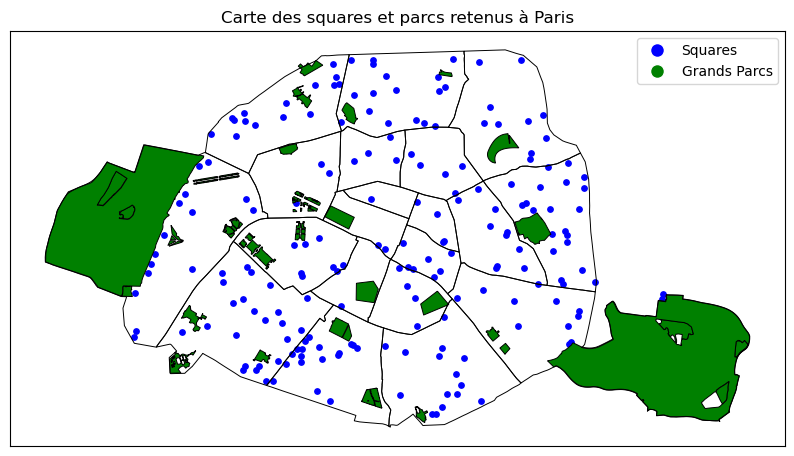

In [29]:
"""Visualisation des squares sur une carte"""
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_squares.plot(ax=ax, color='blue', markersize=15, label='Squares')
df_grands_parcs.plot(ax=ax, color='green', alpha=1, edgecolor='black', linewidth=0.7, label='Grands parcs')

plt.xticks([], [])
plt.yticks([], [])

# Créez des objets de légende explicites
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Squares'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Grands Parcs')
]

# Ajoutez une légende en utilisant les objets de légende explicites
ax.legend(handles=legend_elements)

plt.title('Carte des squares et parcs retenus à Paris')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_parcs_squares.png')

plt.show()

In [508]:
"""Fonction qui merge les data set en trouvant le parc (polygone) le plus proche et enregistre la distance (en km)"""

def ajout_grands_parc(dvf, df_grands_parcs):

    #sélection des variables
    var_parcs = ['nom_ev', 'geometry']
    df_grands_parcs = df_grands_parcs[var_parcs].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_grands_parcs = df_grands_parcs.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_grands_parcs, how="left", max_distance=5000, distance_col="dist_min_grand_parc")

    #dist en km
    merged_nearest['dist_min_grand_parc'] = merged_nearest['dist_min_grand_parc']/1000

    #repasser en système de projection wgs 84
    dvf_avec_parc = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_parc = dvf_avec_parc.drop(['index_right'], axis=1)    
    dvf_avec_parc = dvf_avec_parc.rename(columns={'nom_ev': 'nom_grand_parc'})

    return dvf_avec_parc

In [506]:
"""Fonction qui merge les data set en trouvant le square (point) le plus proche et enregistre la distance (en km)"""

def ajout_squares(dvf, df_squares):

    #sélection des variables
    var_squares = ['nom_ev', 'geometry']
    df_squares = df_squares[var_squares].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_squares = df_squares.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = sjoin_nearest(dvf, df_squares, how="left", max_distance=5000, distance_col="dist_min_square")

    #dist en km
    merged_nearest['dist_min_square'] = merged_nearest['dist_min_square']/1000

    #repasser en système de projection wgs 84
    dvf_avec_squares = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_squares = dvf_avec_squares.drop(['index_right'], axis=1)    
    dvf_avec_squares = dvf_avec_squares.rename(columns={'nom_ev': 'nom_square'})

    return dvf_avec_squares

In [494]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)

In [495]:
"""Ajouter les squares"""

dvf_avec_squares = ajout_squares(dvf, df_squares)

In [507]:
"""Ajouter les parcs"""

dvf_avec_squares_et_parc = ajout_grands_parc(dvf_avec_squares, df_grands_parcs)

In [509]:
"""Exporter le fichier"""

#chemin export
outer_path = '3.1) Données enrichies/'
outer_name = 'dvf_concat_2021_to_2023_avec_espaces_verts.geojson'

#exportation
dvf_avec_squares_et_parc.to_file(outer_path+outer_name, driver='GeoJSON')

=============================================================================

Ci-dessous : 
Tentatives précédentes pour trouver le parc le plus proche : boucle for, et réaliser le projeté de l'appartement sur tous les parcs, puis calculer à la main la distance.

In [491]:
"""Test de la procédure de projection"""
appartement = df.index.tolist()[0] #on prend le premier appartement

#on récupère les coordonnées de l'appartement
long = df.loc[appartement]['longitude']
lat = df.loc[appartement]['latitude']
coord_app = [long,lat]

#on prend les 20 plus grands espaces verts
espaces_verts_test = df_espaces_verts.sort_values(by='poly_area', ascending=False).head(20) 

#on récupère pour chaque espace vert le point le plus proche de l'appartement avec la fonction nearest_points
list_nearest_points = []
for esp in espaces_verts_test.index.tolist():
    np, _ = nearest_points(espaces_verts_test.loc[esp]['geometry'],Point(coord_app))
    np = gpd.GeoSeries(np)
    coord_nearest_point = [np.x[0],np.y[0]]
    list_nearest_points.append(coord_nearest_point)

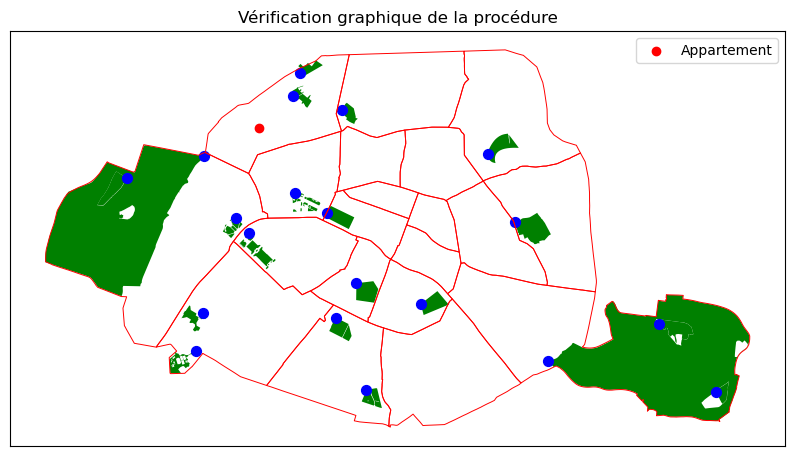

In [492]:
"""Vérification graphique de la procédure de projeté, qu'on utilisera pour trouver le parc le plus proche"""

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor="red", linewidth=0.7)

espaces_verts_test.plot(ax=ax, color='green')

#on ajoute l'appartement
ax.scatter(*coord_app, color='red', label='Appartement')

#on ajoute les points les plus proches
for point in list_nearest_points:
    ax.scatter(*point, color='blue', marker='o', s=50)

ax.legend()

# Add a title
plt.title("Vérification graphique de la procédure")
plt.xticks([], [])
plt.yticks([], [])

# Show the plot
plt.show()

In [489]:
"""On créée la fonction qui trouve le parc le plus proche pour chaque appartement, 
et trouve : la distance minimale, le nom du parc"""

def ajouter_dist_grand_parcs(dvf, df_grands_parcs):
    
    dvf['dist_min_parc'] = 100.0  # On initialise la distance maximale
    dvf['nom_grand_parc_proche'] = '' #on initialise la colonne du nom de parc
    
    # On va trouver pour chaque appartement l'espace vert le plus proche et ajouter la distance
    for ind in tqdm(dvf.index.tolist(), desc="Calculating distances"):
        # Récupérer les coordonnées de l'appartement
        long = dvf.loc[ind]['longitude']
        lat = dvf.loc[ind]['latitude']
        coord_app = [long, lat]  # gpd.GeoSeries([Point(lat,long)])

        # Trouver la distance la plus faible
        dist = 100.0  # initialisation de la distance
        nom_esp_vert_proche = None  # Initialisation du nom du parc le plus proche

        # On fait défiler chacun des espaces verts
        for esp_vert in df_grands_parcs.index.tolist():
            # On récupère le projeté du point de l'appartement sur le polygone de l'espace vert, puis on calcule la distance
            np, _ = nearest_points(df_espaces_verts.loc[esp_vert]['geometry'], Point(coord_app))
            np = gpd.GeoSeries(np)
            d = GD([np.x[0], np.y[0]], coord_app).km

            # Si la distance trouvée est plus faible que la précédente, on met à jour
            if d < dist:
                dist = d
                nom_esp_vert_proche = df_espaces_verts.loc[esp_vert]['nom_ev']

        # On met à jour la distance minimale et le nom du parc le plus proche dans le dataframe
        dvf.loc[ind, 'dist_min_parc'] = dist
        dvf.loc[ind, 'nom_grand_parc_proche'] = nom_esp_vert_proche

    return dvf


In [488]:
"""Fonction qui applique ajouter_dist_parcs et exporte le fichier"""

def ajout_parcs_export(dvf, outer_path):

    #on applique la fonction ajouter_dist_parcs
    dvf_enrichi = ajouter_dist_parcs(dvf, df_espaces_verts)

    #nom du fichier de sortie
    name_file_without_extension = os.path.splitext(name_file)[0]
    outer_name = f'{name_file_without_extension}_avec_parcs.geojson'

    #on exporte
    dvf_enrichi.to_file(outer_path+outer_name, driver='GeoJSON')

    return dvf_enrichi